# Analiza Danych 2023/2024
#### Tytuł: Analiza czynników wywołujących pożary lasów
#### Wykonawca: Mateusz Jurek (240692)
W ramach niniejszego projektu przeprowadzono analizę danych dotyczących pożarów lasów, skoncentrowaną na identyfikowaniu czynników wpływających na występowanie i rozwój tych zdarzeń. Analizowany zbiór danych obejmuje różnorodne parametry atmosferyczne i przestrzenne zebrane podczas pożarów w Parku Montesinho w Portugalii.

Zbiór danych, który posłużył za podstawę analizy, został pozyskany ze zbioru dostępnego na stronie UCI Machine Learning Repository. Celem projektu jest zidentyfikowanie okresów, w których pożary lasu były najczęstsze, a także zrozumienie, jakie czynniki atmosferyczne i przestrzenne miały istotny wpływ na występowanie pożarów. Poprzez analizę tych danych, projekt ma na celu dostarczenie głębszego zrozumienia warunków sprzyjających pożarom lasów oraz identyfikację potencjalnych czynników ryzyka


W analizowanym zbiorze danych znajdziemy takie wartości ja:

* X: współrzędna przestrzenna osi X na mapie parku Montesinho
* Y: współrzędna przestrzenna osi Y na mapie parku Montesinho
* month: miesiąc roku
* day: dzień tygodnia
* FFMC: Indeks wilgotności materiału palnego
* DMC: Indeks wilgotności ściółki leśnej
* DC: Indeks suszy
* ISI: Indeks początkowego rozprzestrzeniania (związany z wiatrem i FFMC)
* temp: temperatura w stopniach Celsjusza
* RH: wilgotność względna w %
* wind: prędkość wiatru w km/h
* rain: opady deszczu na zewnątrz w mm/m*
* area: spalona powierzchnia lasu (w ha)

# 1. Importowanie potrzebnych bibliotek

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 2. Wczytywanie danych

In [20]:
df = pd.read_csv('forestfires.csv')
df.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# 3. Wstępna obróbka danych

In [21]:
# Wyświetlam wiersze które nie są całkowiecie wypełnione danymi
df[df.isnull().any(axis=1)]

# Usuwam te wiersze
df = df.dropna().reset_index(drop=True)

In [22]:
# Ustawiam typ danych jako tekstowe dla: dni tygodnia oraz nazwy miesięcy
df = df.astype({'month':'string'})
df = df.astype({'day':'string'})

In [23]:
# W celu lepszego obrazowania danych, dodaję kolejną kolumnę o nazwie 'size_category'.
# Będzie ona zawierała wartość 0 lub 1.
# 0 oznacza mały pożar (do 5 ha)
# 1 oznacza duży pożar (powyżej 5 ha)

df['size_category'] = np.where(df['area'] > 5, '1', '0')
df['size_category']=pd.to_numeric(df['size_category'])
df.tail(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,1
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,1
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,1
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.00,0


### 3.1 Sprawdzenie poprawnosci danych
Analizowane dane wydają się mieć prawidłowe wartości co do swoich typów i przeznaczenia.
Wnioskuję to na podstawie danych zawartych w tabeli jak przykładowo:
* współżędne X/Y nie osiągają ujemnych wartości
* współczynnik wilgotności wyrażany w % jest w dozwolonym zakresie 0-100%
* obszar pożaru nie osiąga w żadnym wypadku wartości mniejszej od 0. Co więcej, analizowany obszar ma powierzchnię 21,278 km2 co przekłada się na 2127,8 ha (2127,8 > 1090,84).	
* Maksymalna temperatura osiąga do 33,3 stopnia Celcjusza, a minimalnie 2,2 stopnia co jest akceptowalne dla klimatu panującego w północnej 
* Indeks rozprzestrzeniania się ognia nie spada poniżej zera. 

In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


# 4. Analiza danych

### 4.1 Informacje ogólne

Z przedstawionych informacji wiemy:
    - jest 517 wierszy z danymi
    - jest 14 kolumn z danymi
    - znamy typy danych w danej kolumnie

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              517 non-null    int64  
 1   Y              517 non-null    int64  
 2   month          517 non-null    string 
 3   day            517 non-null    string 
 4   FFMC           517 non-null    float64
 5   DMC            517 non-null    float64
 6   DC             517 non-null    float64
 7   ISI            517 non-null    float64
 8   temp           517 non-null    float64
 9   RH             517 non-null    int64  
 10  wind           517 non-null    float64
 11  rain           517 non-null    float64
 12  area           517 non-null    float64
 13  size_category  517 non-null    int64  
dtypes: float64(8), int64(4), string(2)
memory usage: 56.7 KB


## 4.2 Macierz korelacji

Na podstawieponiższejj macierzy widać, że istnieje kilka kwadratów o różnych kolorach, reprezentujących korelację pomiędzy parami zmiennych.Im wartość bardziej odbiega od 0r, tym silniejsza korelacja między obiema zmiennymi.

Na podstawie wyników próbowałem pominąć FFMC/DMC/DC w funkcji temperatury, jednak wyniki dotyczące dokładności modelu pozostały takie same. Korelacja nie implikuje związku przyczynowego.

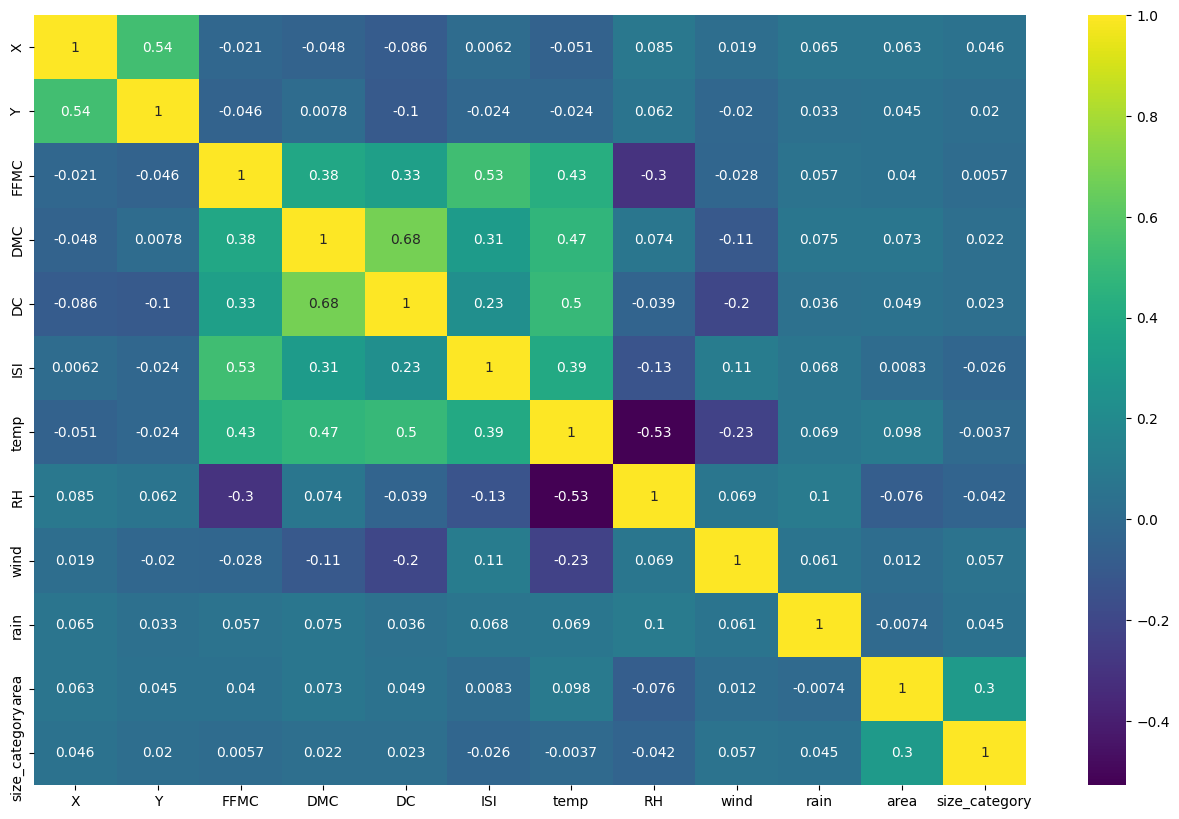

In [26]:
fig, ax = plt.subplots(figsize=(16,10))  
dataplot = sns.heatmap(df.corr(numeric_only = True), cmap="viridis", annot=True)
plt.show()

### 4.3 Występowanie pożarów w kolejnych miesiącach roku
Poniższy wykres przedstawia liczbę pożarów w danym miesiącu. Już na pierwszy rzut oka widać, że strażacy najwięcej pracy mają w okresie wakacji tj. sierpień i wrzesień. W tym czasie ma miejsce największa ilość pożarów i jest to znaczna wartość w porównaniu do innych okresów. Co zaskakujące, dużą liczbę incydentów odnotowujemy w miesiącu marzec. Jest to wartość o około 65% mniejsza od tych w pełni 'sezonu pożarowego', ale mimo to wyróżniająca się na tle innych miesięcy. Jeśli chodzi o najmniejsze wartości to występują one w miesiącach styczeń, maj oraz listopad. W wymienionych okresach notowano do dwóch pożarów

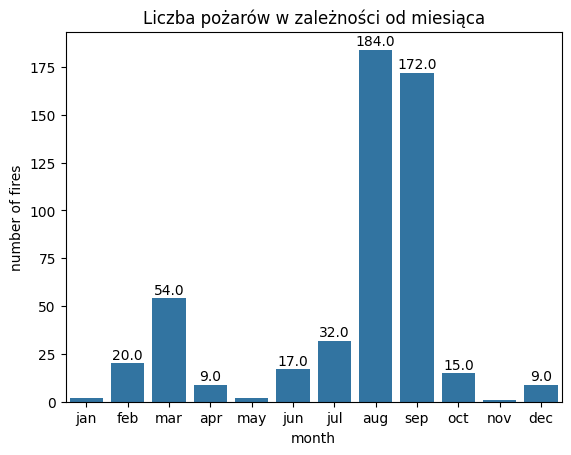

In [27]:
order_of_months = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

ax = sns.countplot(x=df['month'], order=order_of_months)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()-3),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylabel('number of fires')

plt.title('Liczba pożarów w zależności od miesiąca')
plt.show()

### 4.4 Występowanie pożarów w porach roku
Poniższy wykres ilustruje liczbę pożarów w zależności od pory roku. Wyróżniamy cztery główne pory roku: wiosna, lato, jesień i zima. Nie da się ukryć,
że na pierwszym miejscu pod względem liczby incydentów stoi sezon letni. Nie jest to wielkie zaskoczenie, gdyż w tym okresie temperatura powietrza w Portugalii osiąga najwyższe wartości, a w połączeniu ze znikomą liczbą opadów atmosferycznych - panuje tam susza. Dowiadujemy się również, że strażacy najmniej pracy mieli jesienią, gdyż ze zgromadzonych danych wynika, iż było to niecałe 4% wyniku z wakacji.

Spójrzmy jeszcze na wykres zestawiający lato do reszty pór roku. Dominacja wakacyjnego okresu dalej jest znaczna. Inne okresy stanowią zaledwie 28% wyniku w wakacji.

Text(0.5, 1.0, 'Ilość pożarów w porach roku')

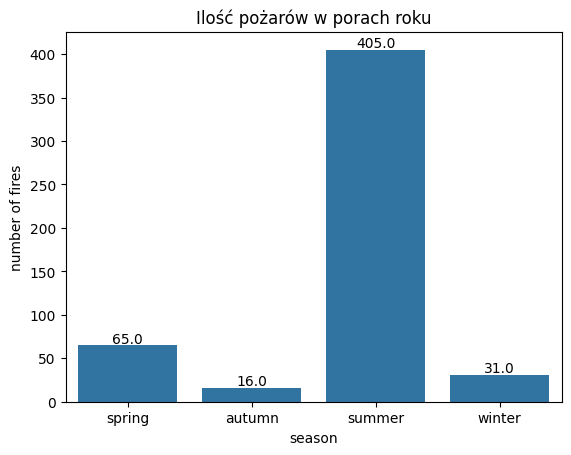

In [28]:
season_dict = {'dec' : 'winter', 'jan' : 'winter', 'feb' : 'winter',
              'mar' : 'spring', 'apr' : 'spring', 'may' : 'spring',
              'jun' : 'summer', 'jul' : 'summer', 'aug' : 'summer', 'sep' : 'summer',
              'oct' : 'autumn', 'nov' : 'autumn'}

df['season'] = df['month'].map(season_dict)

ax = sns.countplot(x = df['season'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() - 9),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylabel('number of fires')

plt.title('Ilość pożarów w porach roku')

Text(0, 0.5, 'number of fires')

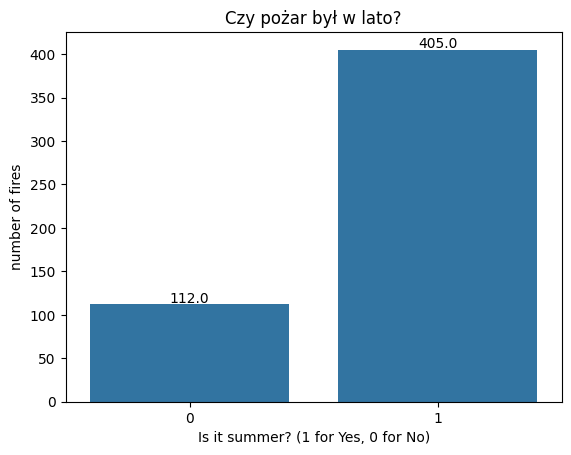

In [29]:
df['is_summer'] = df['season'].apply(lambda x: 1 if x == 'summer' else 0)

ax = sns.countplot(x=df['is_summer'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() - 9),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Czy pożar był w lato?')
plt.xlabel('Is it summer? (1 for Yes, 0 for No)')
plt.ylabel('number of fires')

### 4.5 Występowanie pożarów w zależności od dnia
Wykres pokazuje, że najwięcej pożarów lasów występuje w niedziele. To może być zaskakujące, ponieważ weekend to czas, gdy ludzie często spędzają czas na świeżym powietrzu. Wysoka liczba pożarów w niedziele może wynikać z różnych czynników, takich jak zwiększona aktywność rekreacyjna lub warunki atmosferyczne. Pomimo największej liczby pożarów w niedziele, ogólna liczba pożarów między dniami tygodnia na pozostałych dniach jest stosunkowo stabilna. Warto zauważyć, że zarówno dni robocze, jak i weekendowe wydają się podobne pod względem ilości pożarów. Zauważono, że najmniej pożarów występuje w czwartki. To może sugerować, że czwartki są dniem o niższej aktywności pożarowej w porównaniu do innych dni.

Analiza liczby pożarów między dniami roboczymi a weekendem nie wykazuje wyraźnej różnicy. To oznacza, że warunki atmosferyczne, ludzka aktywność i inne czynniki wpływające na występowanie pożarów mogą być stosunkowo zbliżone w obu okresach.

Text(0.5, 1.0, 'Liczba pożarów w zależności od dnia tygodnia')

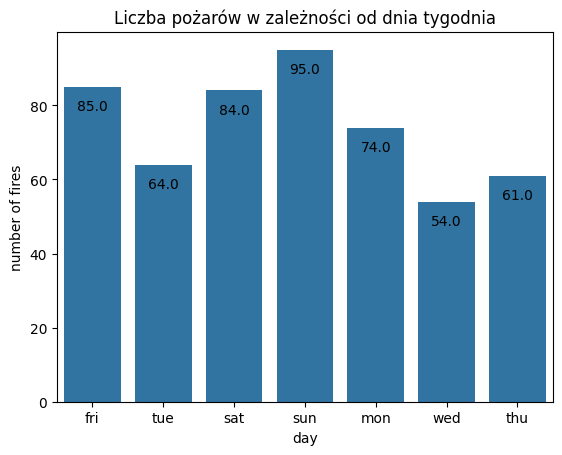

In [30]:
ax = sns.countplot(x=df['day'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height() - 9),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylabel('number of fires')

plt.title('Liczba pożarów w zależności od dnia tygodnia')

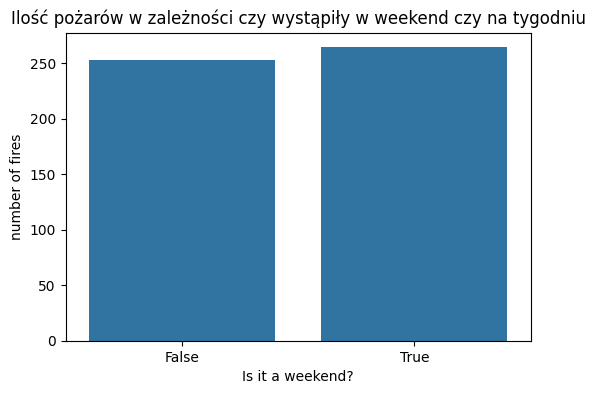

In [31]:
df['is_weekend'] = df['day'].isin(['fri', 'sat', 'sun'])

plt.figure(figsize=(6, 4))
sns.countplot(x=df['is_weekend'])

plt.title('Ilość pożarów w zależności czy wystąpiły w weekend czy na tygodniu')
plt.xlabel('Is it a weekend?')
plt.ylabel('number of fires')
plt.show()

### 4.5 Badanie przyczyn wystąpienia pożarów
Analiza danych dotyczących przyczyn pożarów lasów wykazała kilka istotnych obserwacji:

**a) Indeks Suszy a Liczba Pożarów**
* Najwięcej pożarów występowało w okolicach wartości indeksu suszy od 600 do 800. Nieco zaskakujące jest jednak zauważalne występowanie pożarów przy niskim indeksie suszy, co sugeruje, że inne czynniki mogą również wpływać na ryzyko pożarów.

**b) Opady Deszczu a Liczba Pożarów**
* Duża liczba pożarów zanotowano przy niskich opadach deszczu, prawie przy braku deszczu. To może wskazywać na fakt, że warunki suchego podłoża zwiększają ryzyko pożarów, nawet gdy opady deszczu są minimalne.

**c) Wiatr a Wielkość Spalonej Powierzchni**
* Nie zaobserwowano wyraźnej zależności między prędkością wiatru a wielkością spalonej powierzchni. To może wynikać z faktu, że w czasie wystąpienia wszystkich pożarów wiatr był stosunkowo słaby.

**d) Temperatura i Wilgotność w Zależności od Pory Roku**
* Latem i jesienią najwięcej pożarów występowało przy umiarkowanych temperaturach od 15 do 25 stopni Celsiusa, przy wilgotności względnej w okolicach 40%. Zimą i wiosną pożary były bardziej skoncentrowane przy niższych temperaturach (5-15 stopni) i nieco wyższej wilgotności względnej (ok. 50%).

Text(0, 0.5, 'Relative Humidity (%)')

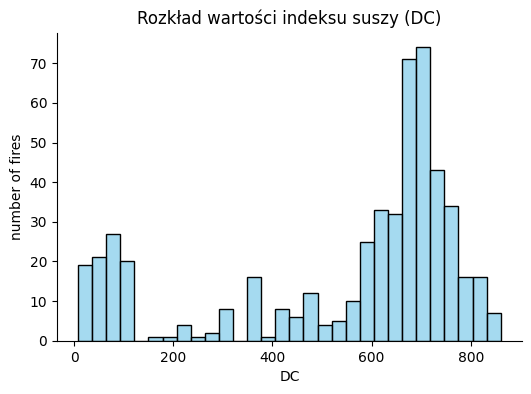

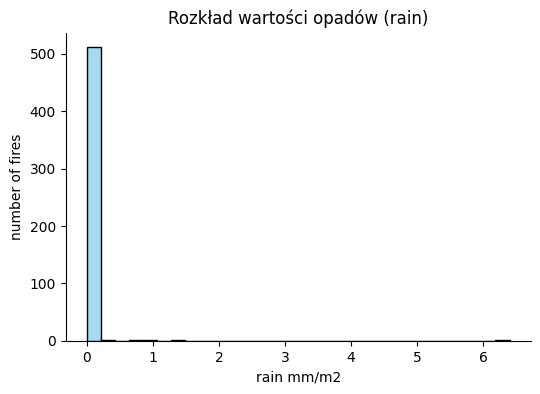

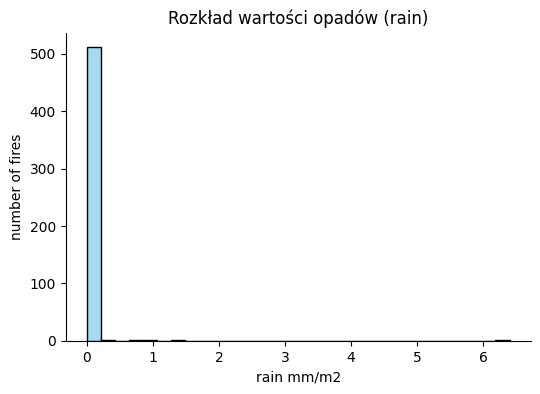

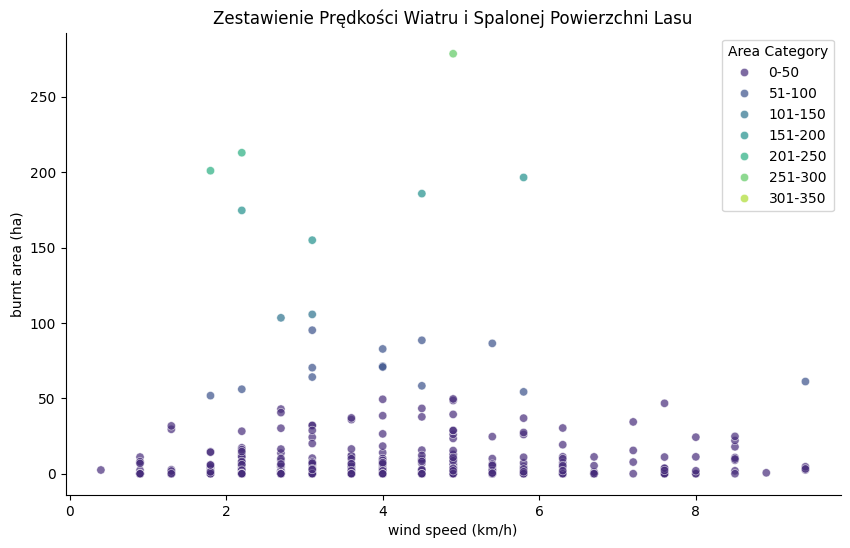

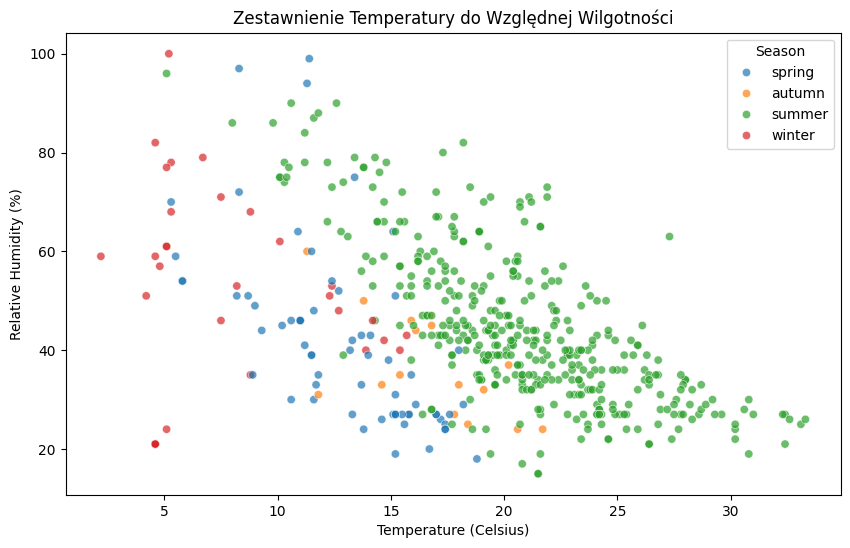

In [32]:
## -------------- DC --------------
plt.figure(figsize=(6, 4))
sns.histplot(df['DC'], bins=30, color='skyblue', kde=False)

plt.title('Rozkład wartości indeksu suszy (DC)')
plt.xlabel('DC')
plt.ylabel('number of fires')
sns.despine(top=True, right=True)


## -------------- TEMPERATURA --------------
plt.figure(figsize=(6, 4))
sns.histplot(df['rain'], bins=30, color='skyblue', kde=False)

plt.title('Rozkład wartości opadów (rain)')
plt.xlabel('rain mm/m2')
plt.ylabel('number of fires')
sns.despine(top=True, right=True)


## -------------- TEMPERATURA --------------
plt.figure(figsize=(6, 4))
sns.histplot(df['rain'], bins=30, color='skyblue', kde=False)

plt.title('Rozkład wartości opadów (rain)')
plt.xlabel('rain mm/m2')
plt.ylabel('number of fires')
sns.despine(top=True, right=True)


## -------------- ZESTAWIENIE WIATRU DO SPALONEJ POWIERZCHNI --------------
# Dodanie kategorii 'area_category' do DataFrame
df['area_category'] = pd.cut(df['area'], bins=[0, 50, 100, 150, 200, 250, 300, 350], labels=['0-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350'], include_lowest=True)

# Tworzenie scatter plotu z różnymi kolorami dla kategorii 'area_category'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind', y='area', hue='area_category', data=df, palette='viridis', alpha=0.7)

# Ustawienia osi i tytułu
plt.title('Zestawienie Prędkości Wiatru i Spalonej Powierzchni Lasu')
plt.xlabel('wind speed (km/h)')
plt.ylabel('burnt area (ha)')

# Usunięcie górnej i prawej krawędzi osi
sns.despine(top=True, right=True)

# Legenda
plt.legend(title='Area Category')


## -------------- ZESTAWIENIE WIATRU DO SPALONEJ POWIERZCHNI --------------
# Tworzenie scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temp', y='RH', data=df, hue='season', alpha=0.7)

# Dodawanie legendy
plt.legend(title='Season')

# Dodawanie tytułu i etykiet osi
plt.title('Zestawnienie Temperatury do Względnej Wilgotności')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Relative Humidity (%)')

# 5. Klasyfikatory

Analiza wybranych klasyfikatorów - DecisionTree, GaussianNB oraz SVC - wykazała różnice w ich skuteczności klasyfikacyjnej. DecisionTree i GaussianNB osiągnęły imponującą dokładność na poziomie około 99%, podczas gdy SVC (Support Vector Classifier) uzyskał nieco niższą dokładność, wynoszącą około 91%.

Przyczyny tych różnic mogą wynikać z charakterystyki samego algorytmu oraz właściwości zbioru dany.h
DecisionTree to algorytm drzewa decyzyjnego, który doskonale radzi sobie z danymi, które posiadają wyraźne reguły i struktury. Jeśli zbiór danych jest dość zróżnicowany i posiada wyraźne separacje, to drzewo decyzyjne może skutecznie się dostosować, co tłumaczy wysoką dokładność.

GaussianNB, czyli klasyfikator Bayesa, zakłada, że cechy są niezależne i podlegają rozkładowi Gaussa. Jeśli dane są zgodne z tymi założeniami, to może osiągnąć wysoką dokładność.
:

SVC jest skutecznym klasyfikatorem, jednak jego wydajność może być obniżona w przypadku dużych i zróżnicowanych zbiorów danych. Jeśli dane są bardziej złożone i nieliniowe, a separacja między klasami nie jest łatwa, to SVM może napotkać trudności, co może prowadzić do nieco niższej dokładności.

### 5.1 Podzielenia danych na testowe i treningowe
Będziemy próbować przyklasyfikować dane do odpowiedniej pory roku.

In [33]:
df = df.drop(['day'], axis = 1)
df = df.drop(['month'], axis = 1)
df = df.drop(['area_category'], axis = 1)

df.info()

features = df.drop(['season'], axis = 1)
labels = df['season'].values.reshape(-1, 1)

rand_val=random.randint(0, 111)     
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3, random_state=rand_val)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              517 non-null    int64  
 1   Y              517 non-null    int64  
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    int64  
 12  season         517 non-null    object 
 13  is_summer      517 non-null    int64  
 14  is_weekend     517 non-null    bool   
dtypes: bool(1), float64(8), int64(5), object(1)
memory usage: 57.2+ KB


### 5.2 Klasyfikator Decision Tree

Accuracy dec_tree:  96.15384615384616


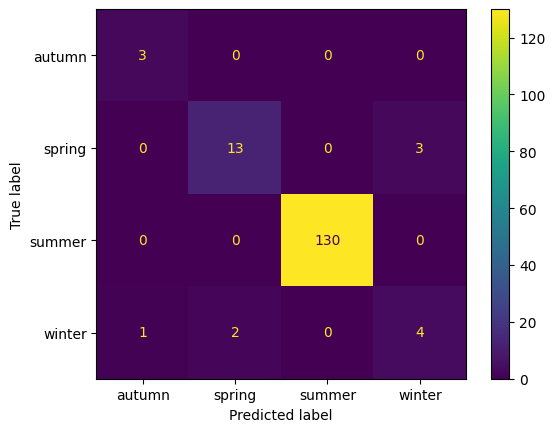

In [34]:
dec_tree = DecisionTreeClassifier(criterion='gini', random_state=random.randint(0,111))

dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test)

print("Accuracy dec_tree: ", accuracy_score(y_test,y_pred)*100)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 5.3 Klasyfikator GaussianNB

Accuracy gaussian_nb:  97.43589743589743


C:\Users\matuj\anaconda3\envs\analiza\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


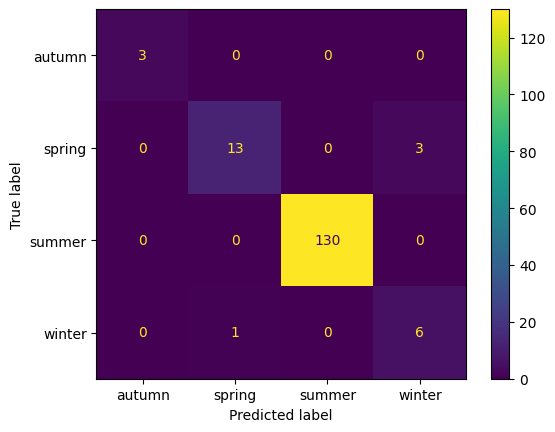

In [35]:
gaussian_nb = GaussianNB()

gaussian_nb.fit(X_train, y_train)
y_pred = gaussian_nb.predict(X_test)

print ("Accuracy gaussian_nb: ", accuracy_score(y_test,y_pred)*100)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 5.3 Klasyfikator SVC

Accuracy svc_classifier:  93.58974358974359


C:\Users\matuj\anaconda3\envs\analiza\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


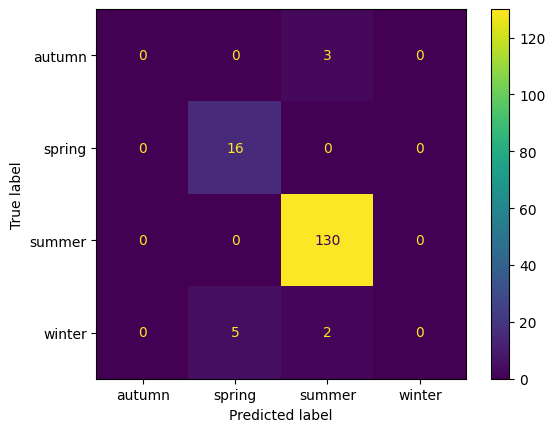

In [36]:
svc_classifier = SVC(C=1.0, random_state=random.randint(0,111))

svc_classifier.fit(X_train, y_train)
y_pred = svc_classifier.predict(X_test)
print ("Accuracy svc_classifier: ", accuracy_score(y_test,y_pred)*100)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# 6. Podsumowanie

Projek dotyczący analizyh pożarów lasów przyniósł istotne spostrzeżenia. Sprawdzenie poprawności danych potwierdziło ich rzetelność. Analiza sezonów i miesięcy wykazała, że najwięcej pożarów występuje latem, zwłaszcza w sierpniu i wrześniu. Dni niedzielne wydają się bardziej narażone na pożary. Badanie przyczyn ujawniło związek między wysokim indeksem suszy, niskimi opadami deszczu a liczbą pożarów.

Eksperyment z trzema klasyfikatorami wykazał, że DecisionTree i GaussianNB osiągają wysoką dokładność, podczas gdy SVC uzyskuje niższe wyni

Wnioski z projektu mają praktyczne zastosowanie w dziedzinie zarządzania leśnictwem i prewencji pożarowej. Wskazują one na konieczność skoncentrowania się na monitorowaniu warunków atmosferycznych i opracowywaniu strategii prewencyjnych, zwłaszcza w okresach największego ryzyka. Dalsze badania mogą być ukierunkowane na doskonalenie modeli klasyfikacyjnych w celu precyzyjniejszego prognozowania obszarów zagrożonych pożarami lasów.ki.